Experimenting with estimating the gender of mailing list participants.

In [10]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [11]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import imp
imp.reload(process)

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

from bigbang import parse
from gender_detector import gender_detector as gd

Now let's load the data for analysis.

In [12]:
urls = ["http://www.ietf.org/mail-archive/text/ietf-privacy/",
        "http://lists.w3.org/Archives/Public/public-privacy/"]
mlists = [(url, mailman.open_list_archives(url,"../../archives")) for url in urls]
#activities = [Archive.get_activity(Archive(ml)) for ml in mlists]

For each of our lists, we'll clean up the names, find the first name if there is one, and guess its gender. Pandas groups the data together for comparison. We keep count of the names we find that are ambiguous, for the next step.

In [13]:
detector = gd.GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

def ml_shortname(url):
    return url.rstrip("/").split("/")[-1]

series = []  
for (url, ml) in mlists:
    activity = Archive.get_activity(Archive(ml)).sum(0)
    activityFrame = pd.DataFrame(activity, columns=['Message Count'])
    
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_from(x))    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    activityFrame.to_csv(('senders_guessed_gender-%s.csv' % ml_shortname(url)),encoding='utf-8')
    
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].count()
    counts.name=url
    series.append(counts)

pd.DataFrame(series)

,female,male,name unknown,unknown,error
http://www.ietf.org/mail-archive/text/ietf-privacy/,7.0,77.0,15.0,33.0,NaN
http://lists.w3.org/Archives/Public/public-privacy/,19.0,102.0,29.0,37.0,1.0


Let's quickly visualize the names that couldn't be guessed with our estimator and their distribution.

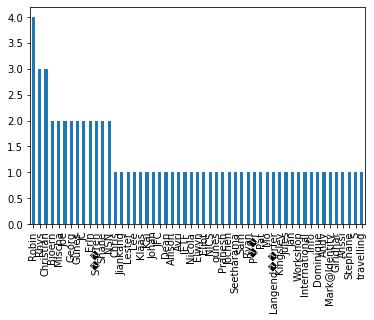

In [14]:
ser = pd.Series(gender_ambiguous_names)
ser.sort_values(ascending=False).plot(kind='bar')

This distribution may vary by the particular list, but it seems to be a power distribution. That is, with a fairly small supplement of manually providing genders for the names/identities on the list, we can very signficantly improve the fraction of messages with an estimated gender.

With a couple minutes of manual work from someone familiar with the group, I've created an updated CSV that contains a manually-entered gender column, in addition to the automated guess. Let's see how much of a difference that makes.

In [6]:
url = "http://lists.w3.org/Archives/Public/public-privacy/"
csv_guessed = ('senders_guessed_gender-%s.csv' % ml_shortname(url))
csv_manual = ('senders_manual_gender-%s.csv' % ml_shortname(url))

guessed = pd.read_csv(csv_guessed)
manual = pd.read_csv(csv_manual)

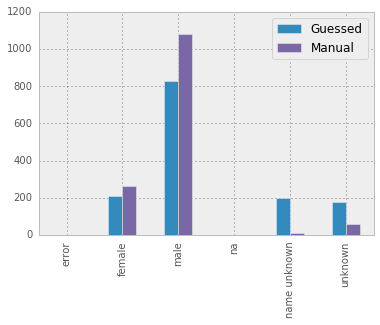

In [7]:
def combined_gender(row):
    if str(row['Manual Gender']) != 'nan':
        return row['Manual Gender']
    else:
        return row['Guessed Gender']
manual['Combined Gender'] = manual.apply(combined_gender, axis=1)

combined_series = manual.groupby('Combined Gender')['Message Count'].sum()
guessed_series = manual.groupby('Guessed Gender')['Message Count'].sum()
compared_counts = pd.DataFrame({'Manual':combined_series, 'Guessed':guessed_series})
compared_counts.plot(kind='bar')

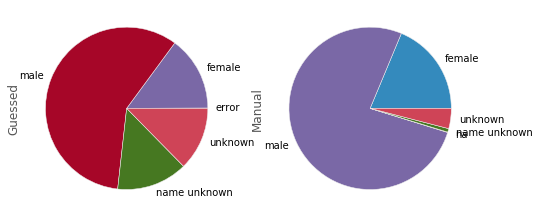

In [8]:
figure,axes = plt.subplots(ncols=2, figsize=(8,4))
guessed_series.rename("Guessed").plot(kind='pie', ax=axes[0])
combined_series.rename("Manual").plot(kind='pie', ax=axes[1])
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')